### Data Dictionary

The U.S. National Parks System includes 417 areas including national parks, monuments, battlefields, military parks, historical parks, historical sites, lakeshores, seashores, recreation areas, scenic rivers and trails, and the White House (see map in Figure 1). Every year, hundreds of millions of recreational visitors come to the parks. What do we know about the parks that can affect the visitor counts? Can we forecast the monthly visits to a given park accurately? To derive insights and answer these questions, we take a look at the historical visits data and the parks information released by the National Parks Service (NPS). 

Each observation contains one record per park per month. Here's a detailed description of the variables:

- ParkName: The full name of the park.

- ParkType: The type of the park. For this study we restrict ourselves to the following more frequently visited types: National Battlefield, National Historic Site, National Historical Park, National Memorial, National Monument, National Park, National Recreation Area, and National Seashore.

- Region: The region of the park, including Alaska, Intermountain, Midwest, National Capital, Northeast, Pacific West, and Southeast.

- State: The abbreviation of the state where the park resides.

- Year, Month: the year and the month for the visits.

- lat, long: Latitude and longitude of the park.

- Cost: a simple extraction of the park's entrance fee. Some parks may have multiple levels of entrance fees (differ by transportation methods, age, military status, etc.); for this problem, we only extracted the first available cost information.

- logVisits: Natural logarithm of the recreational visits (with one added to the visits to avoid taking logs of zero) to the park in the given year and month.

- laglogVisits: the logVisits from last month.

- laglogVisitsYear: the logVisits from last year.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

np.random.seed = 0

### Data Exploration

In [2]:
df = pd.read_csv("park_visits.csv")

In [3]:
df

,ParkName,ParkType,Region,State,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
0,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,1,37.585866,-85.673305,0.0,8.263333,NaN,NaN
1,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,2,37.585866,-85.673305,0.0,8.550241,8.263333,NaN
2,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,3,37.585866,-85.673305,0.0,8.994048,8.550241,NaN
3,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,4,37.585866,-85.673305,0.0,9.808022,8.994048,NaN
4,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,5,37.585866,-85.673305,0.0,9.867394,9.808022,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
25582,Zion NP,National Park,Intermountain,UT,2016,8,37.298393,-113.026514,30.0,13.076336,13.304622,13.029125
25583,Zion NP,National Park,Intermountain,UT,2016,9,37.298393,-113.026514,30.0,13.118006,13.076336,12.884619
25584,Zion NP,National Park,Intermountain,UT,2016,10,37.298393,-113.026514,30.0,12.931002,13.118006,12.660223
25585,Zion NP,National Park,Intermountain,UT,2016,11,37.298393,-113.026514,30.0,12.355664,12.931002,12.102882


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25587 entries, 0 to 25586
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ParkName          25587 non-null  object 
 1   ParkType          25587 non-null  object 
 2   Region            25587 non-null  object 
 3   State             25587 non-null  object 
 4   Year              25587 non-null  int64  
 5   Month             25587 non-null  int64  
 6   lat               25503 non-null  float64
 7   long              25503 non-null  float64
 8   cost              25587 non-null  float64
 9   logVisits         25587 non-null  float64
 10  laglogVisits      25282 non-null  float64
 11  laglogVisitsYear  21927 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 2.3+ MB


In [5]:
df.describe(include='all')

,ParkName,ParkType,Region,State,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
count,25587,25587,25587,25587,25587.000000,25587.000000,25503.000000,25503.000000,25587.000000,25587.000000,25282.000000,21927.000000
unique,305,8,7,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Statue of Liberty NM,National Historic Site,Intermountain,CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,84,6288,6300,1680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,2013.003517,6.500410,38.264148,-96.553684,4.997968,9.148891,9.156110,9.123890
std,NaN,NaN,NaN,NaN,1.998863,3.452137,8.170363,26.080984,7.839068,2.389602,2.387873,2.393828
min,NaN,NaN,NaN,NaN,2010.000000,1.000000,-14.228659,-169.850378,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,2011.000000,4.000000,34.983877,-111.113563,0.000000,7.863651,7.872169,7.840116
50%,NaN,NaN,NaN,NaN,2013.000000,7.000000,38.564142,-94.355227,0.000000,9.243775,9.248503,9.219796
75%,NaN,NaN,NaN,NaN,2015.000000,10.000000,41.762085,-77.396377,7.000000,10.769821,10.775063,10.757743


In [6]:
df.shape

(25587, 12)

In [7]:
df.columns

Index(['ParkName', 'ParkType', 'Region', 'State', 'Year', 'Month', 'lat',
       'long', 'cost', 'logVisits', 'laglogVisits', 'laglogVisitsYear'],
      dtype='object')

### Data Exploration

In [8]:
df1 = df[df['Year'] == 2016]

In [9]:
df1

,ParkName,ParkType,Region,State,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
72,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2016,1,37.585866,-85.673305,0.0,8.691986,8.523573,8.156797
73,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2016,2,37.585866,-85.673305,0.0,8.652074,8.691986,7.873217
74,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2016,3,37.585866,-85.673305,0.0,9.473166,8.652074,8.787678
75,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2016,4,37.585866,-85.673305,0.0,10.072259,9.473166,9.511037
76,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2016,5,37.585866,-85.673305,0.0,10.081257,10.072259,9.674389
...,...,...,...,...,...,...,...,...,...,...,...,...
25582,Zion NP,National Park,Intermountain,UT,2016,8,37.298393,-113.026514,30.0,13.076336,13.304622,13.029125
25583,Zion NP,National Park,Intermountain,UT,2016,9,37.298393,-113.026514,30.0,13.118006,13.076336,12.884619
25584,Zion NP,National Park,Intermountain,UT,2016,10,37.298393,-113.026514,30.0,12.931002,13.118006,12.660223
25585,Zion NP,National Park,Intermountain,UT,2016,11,37.298393,-113.026514,30.0,12.355664,12.931002,12.102882


In [10]:
visits2016jul = df1[df1['Month'] == 7]

In [11]:
visits2016jul

,ParkName,ParkType,Region,State,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
78,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2016,7,37.585866,-85.673305,0.0,10.873736,10.283088,10.052554
162,Acadia NP,National Park,Northeast,ME,2016,7,44.307775,-68.300633,25.0,13.454333,13.006753,13.315622
246,Adams NHP,National Historical Park,Northeast,MA,2016,7,42.255396,-71.011604,10.0,10.288103,10.182520,10.576942
330,African Burial Ground NM,National Monument,Northeast,NY,2016,7,40.714527,-74.004474,0.0,8.782169,8.584104,9.113829
414,Agate Fossil Beds NM,National Monument,Midwest,NE,2016,7,42.421704,-103.753886,0.0,8.183677,7.996317,7.977625
...,...,...,...,...,...,...,...,...,...,...,...,...
25245,Wright Brothers NMEM,National Memorial,Southeast,NC,2016,7,36.016377,-75.669972,7.0,11.253170,11.057014,11.315328
25329,Wupatki NM,National Monument,Intermountain,AZ,2016,7,35.557411,-111.395722,20.0,10.216655,10.225317,10.275637
25413,Yellowstone NP,National Park,Intermountain,WY,2016,7,44.598244,-110.547170,30.0,13.811420,13.639152,13.796025
25497,Yosemite NP,National Park,Pacific West,CA,2016,7,37.848833,-119.557187,30.0,13.567983,13.463987,13.347122


In [12]:
visits2016jul['ParkType'].value_counts()

National Historic Site      75
National Monument           68
National Park               57
National Historical Park    42
National Memorial           28
National Recreation Area    15
National Battlefield        10
National Seashore           10
Name: ParkType, dtype: int64

In [13]:
visits2016jul['Region'].value_counts()

Intermountain        75
Northeast            65
Southeast            48
Pacific West         47
Midwest              40
National Capital     18
Alaska               12
Name: Region, dtype: int64

In [16]:
pacificwest = visits2016jul[visits2016jul['Region'] == "Pacific West"]

In [17]:
pacificwest

,ParkName,ParkType,Region,State,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear


In [18]:
visits2016jul.corr()

,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,NaN,NaN,1.000000,-0.221511,-0.014517,0.033507,0.008199,-0.047294
long,NaN,NaN,-0.221511,1.000000,-0.170515,-0.012419,0.005281,0.040525
cost,NaN,NaN,-0.014517,-0.170515,1.000000,0.401061,0.398253,0.399685
logVisits,NaN,NaN,0.033507,-0.012419,0.401061,1.000000,0.973283,0.944541
laglogVisits,NaN,NaN,0.008199,0.005281,0.398253,0.973283,1.000000,0.930446
laglogVisitsYear,NaN,NaN,-0.047294,0.040525,0.399685,0.944541,0.930446,1.000000


In [19]:
df

,ParkName,ParkType,Region,State,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
0,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,1,37.585866,-85.673305,0.0,8.263333,NaN,NaN
1,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,2,37.585866,-85.673305,0.0,8.550241,8.263333,NaN
2,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,3,37.585866,-85.673305,0.0,8.994048,8.550241,NaN
3,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,4,37.585866,-85.673305,0.0,9.808022,8.994048,NaN
4,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,5,37.585866,-85.673305,0.0,9.867394,9.808022,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
25582,Zion NP,National Park,Intermountain,UT,2016,8,37.298393,-113.026514,30.0,13.076336,13.304622,13.029125
25583,Zion NP,National Park,Intermountain,UT,2016,9,37.298393,-113.026514,30.0,13.118006,13.076336,12.884619
25584,Zion NP,National Park,Intermountain,UT,2016,10,37.298393,-113.026514,30.0,12.931002,13.118006,12.660223
25585,Zion NP,National Park,Intermountain,UT,2016,11,37.298393,-113.026514,30.0,12.355664,12.931002,12.102882


In [20]:
df['ParkName'].unique()

array(['Abraham Lincoln Birthplace NHP', 'Acadia NP', 'Adams NHP',
       'African Burial Ground NM', 'Agate Fossil Beds NM',
       'Alibates Flint Quarries NM', 'Allegheny Portage Railroad NHS',
       'Amistad NRA', 'Andersonville NHS', 'Andrew Johnson NHS',
       'Aniakchak NM & PRES', 'Antietam NB', 'Appomattox Court House NHP',
       'Arches NP', 'Arkansas Post NMEM',
       'Arlington House The R.E. Lee MEM', 'Assateague Island NS',
       'Aztec Ruins NM', 'Badlands NP', 'Bandelier NM',
       "Bent's Old Fort NHS", 'Big Bend NP', 'Big Hole NB',
       'Bighorn Canyon NRA', 'Biscayne NP',
       'Black Canyon of the Gunnison NP', 'Booker T. Washington NM',
       'Boston African American NHS', 'Boston NHP',
       'Brown v. Board of Education NHS', 'Bryce Canyon NP',
       'Buck Island Reef NM', 'Cabrillo NM', 'Canaveral NS',
       'Cane River Creole NHP', 'Canyon de Chelly NM', 'Canyonlands NP',
       'Cape Cod NS', 'Cape Hatteras NS', 'Cape Krusenstern NM',
       'Cape 

In [21]:
ys = df[df['ParkName'] == 'Yellowstone NP']

In [22]:
ys

,ParkName,ParkType,Region,State,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
25335,Yellowstone NP,National Park,Intermountain,WY,2010,1,44.598244,-110.54717,30.0,10.150191,NaN,NaN
25336,Yellowstone NP,National Park,Intermountain,WY,2010,2,44.598244,-110.54717,30.0,10.278803,10.150191,NaN
25337,Yellowstone NP,National Park,Intermountain,WY,2010,3,44.598244,-110.54717,30.0,9.953658,10.278803,NaN
25338,Yellowstone NP,National Park,Intermountain,WY,2010,4,44.598244,-110.54717,30.0,10.397086,9.953658,NaN
25339,Yellowstone NP,National Park,Intermountain,WY,2010,5,44.598244,-110.54717,30.0,12.430999,10.397086,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
25414,Yellowstone NP,National Park,Intermountain,WY,2016,8,44.598244,-110.54717,30.0,13.642391,13.811420,13.658165
25415,Yellowstone NP,National Park,Intermountain,WY,2016,9,44.598244,-110.54717,30.0,13.461340,13.642391,13.430163
25416,Yellowstone NP,National Park,Intermountain,WY,2016,10,44.598244,-110.54717,30.0,12.396714,13.461340,12.437240
25417,Yellowstone NP,National Park,Intermountain,WY,2016,11,44.598244,-110.54717,30.0,10.115004,12.396714,9.310186


In [23]:
ys.columns

Index(['ParkName', 'ParkType', 'Region', 'State', 'Year', 'Month', 'lat',
       'long', 'cost', 'logVisits', 'laglogVisits', 'laglogVisitsYear'],
      dtype='object')

In [24]:
ys.drop(['ParkName', 'ParkType', 'Region', 'State', 'lat','long', 'cost', 'laglogVisits','laglogVisitsYear'],axis=1,inplace=True)

In [25]:
ys

,Year,Month,logVisits
25335,2010,1,10.150191
25336,2010,2,10.278803
25337,2010,3,9.953658
25338,2010,4,10.397086
25339,2010,5,12.430999
...,...,...,...
25414,2016,8,13.642391
25415,2016,9,13.461340
25416,2016,10,12.396714
25417,2016,11,10.115004


In [26]:
ys.set_index(keys='Year',inplace=True)

In [27]:
ys

,Month,logVisits
Year,,
2010,1,10.150191
2010,2,10.278803
2010,3,9.953658
2010,4,10.397086
2010,5,12.430999
...,...,...
2016,8,13.642391
2016,9,13.461340
2016,10,12.396714


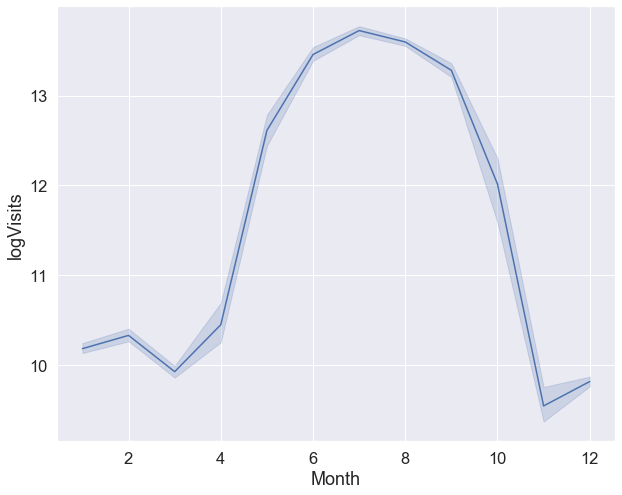

In [28]:
plt.figure(figsize=(10,8))
sns.lineplot(x='Month',y='logVisits', data=ys)
plt.show()

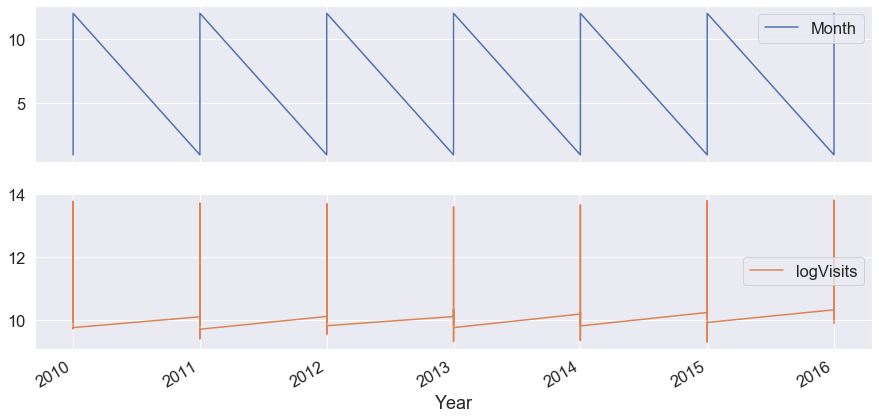

In [29]:
ys.plot(figsize= (15,7),subplots = True);

### Data Visualization

### Univariate Data Exploration

In [30]:
df.corr()

,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
Year,1.000000,-0.000119,-0.000308,0.000876,-0.001087,0.021183,0.014375,0.007505
Month,-0.000119,1.000000,-0.000005,0.000083,-0.000131,0.052714,0.141408,0.052315
lat,-0.000308,-0.000005,1.000000,-0.221606,-0.014656,-0.205528,-0.203844,-0.209480
long,0.000876,0.000083,-0.221606,1.000000,-0.170199,0.079151,0.079036,0.083814
cost,-0.001087,-0.000131,-0.014656,-0.170199,1.000000,0.344047,0.344605,0.342381
logVisits,0.021183,0.052714,-0.205528,0.079151,0.344047,1.000000,0.934311,0.906303
laglogVisits,0.014375,0.141408,-0.203844,0.079036,0.344605,0.934311,1.000000,0.870855
laglogVisitsYear,0.007505,0.052315,-0.209480,0.083814,0.342381,0.906303,0.870855,1.000000


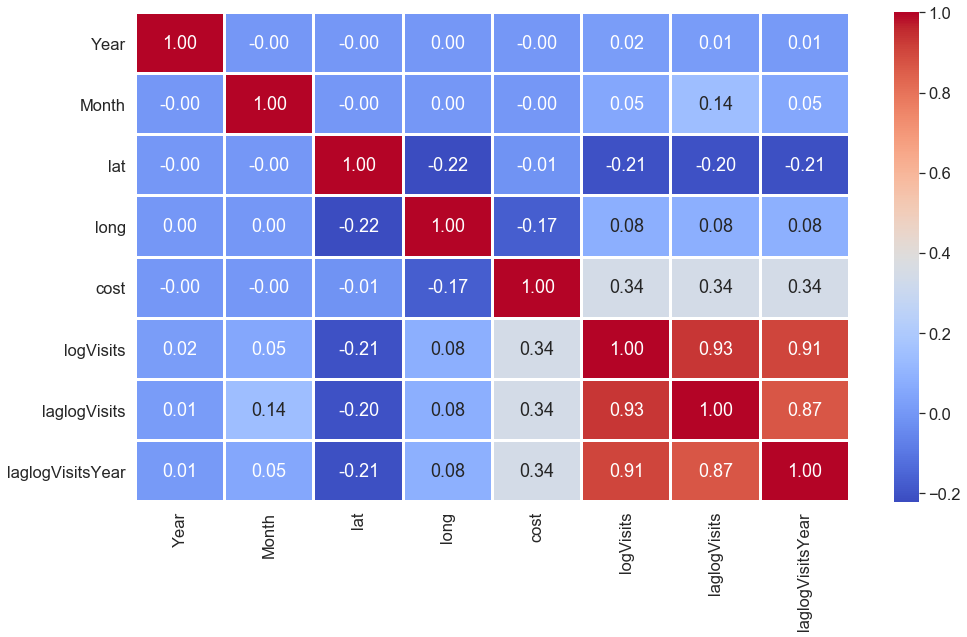

In [31]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

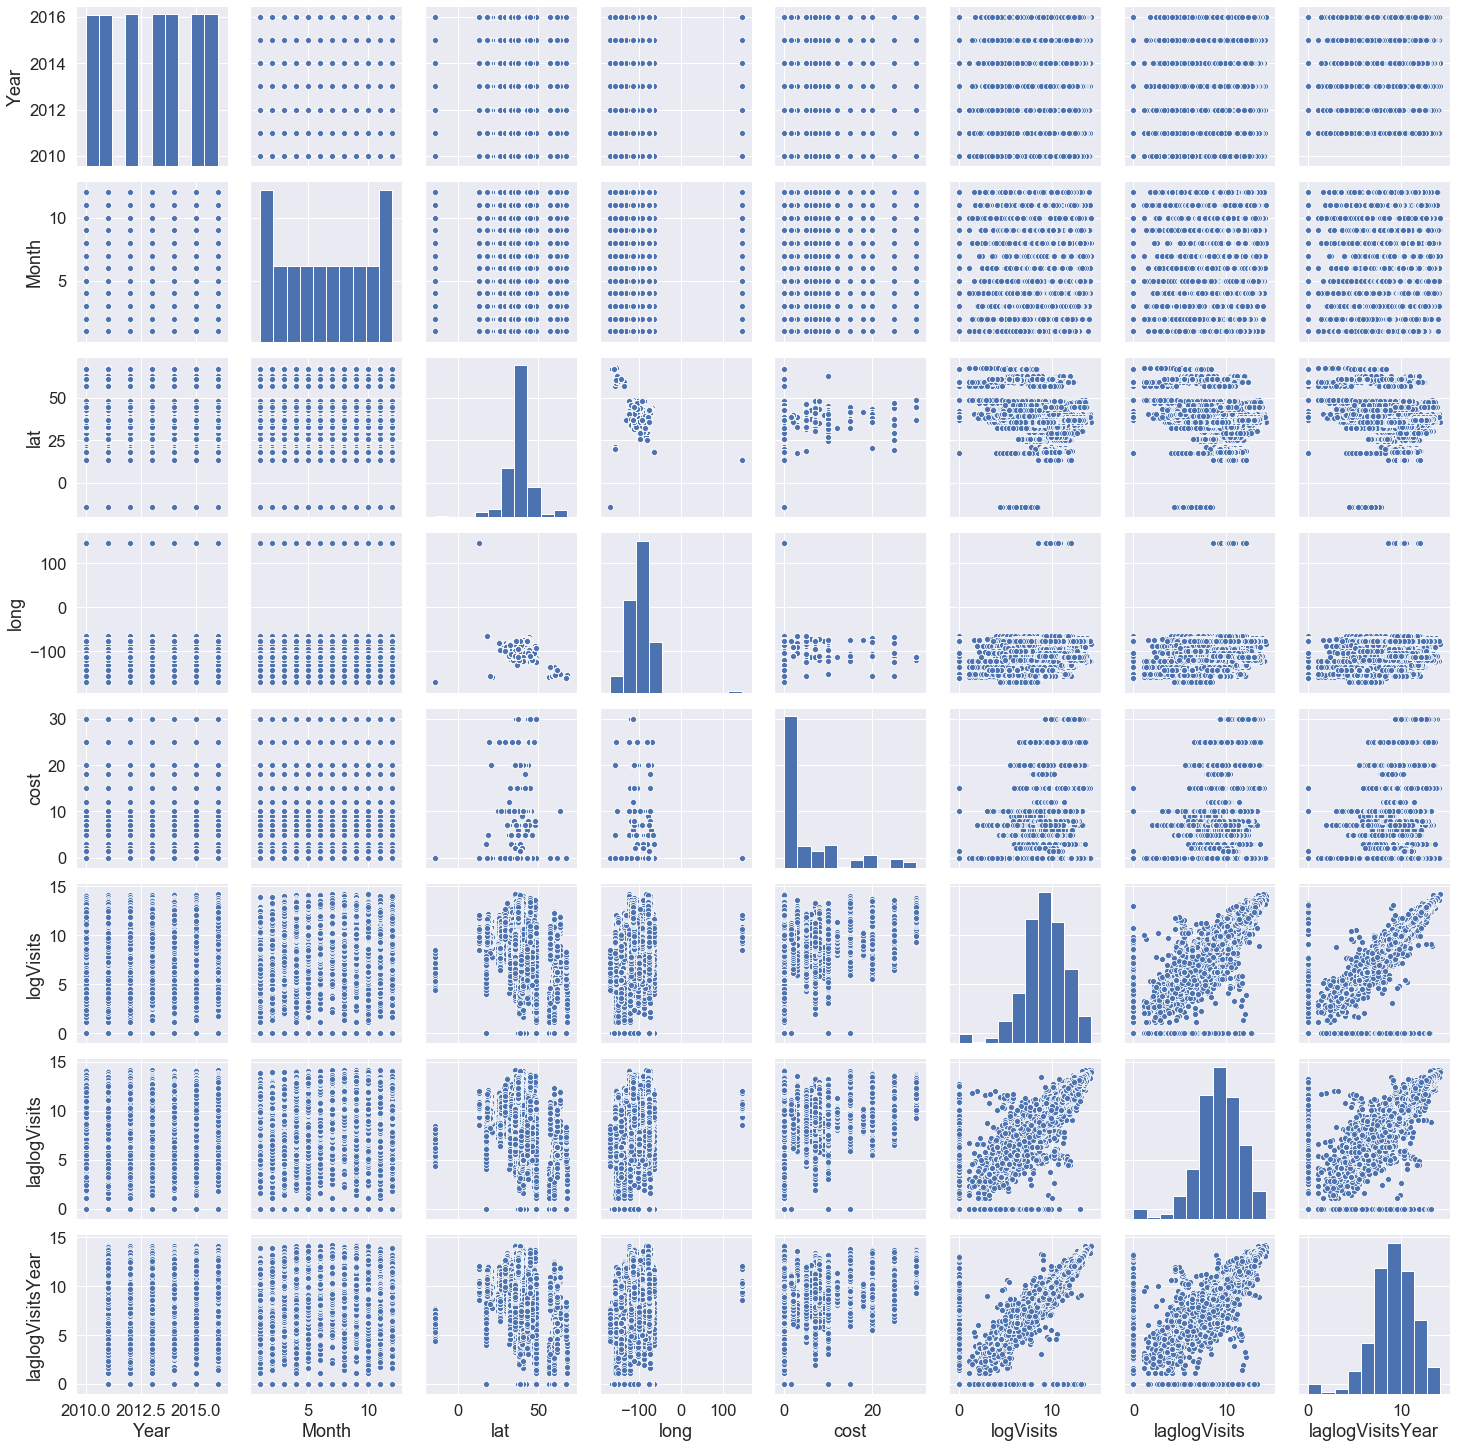

In [32]:
sns.pairplot(df)
plt.show()

### Data Preprocessing

### Treat Missing Values

In [33]:
df.isnull().sum()

ParkName               0
ParkType               0
Region                 0
State                  0
Year                   0
Month                  0
lat                   84
long                  84
cost                   0
logVisits              0
laglogVisits         305
laglogVisitsYear    3660
dtype: int64

In [34]:
df.dropna(inplace=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21855 entries, 12 to 25586
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ParkName          21855 non-null  object 
 1   ParkType          21855 non-null  object 
 2   Region            21855 non-null  object 
 3   State             21855 non-null  object 
 4   Year              21855 non-null  int64  
 5   Month             21855 non-null  int64  
 6   lat               21855 non-null  float64
 7   long              21855 non-null  float64
 8   cost              21855 non-null  float64
 9   logVisits         21855 non-null  float64
 10  laglogVisits      21855 non-null  float64
 11  laglogVisitsYear  21855 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 2.2+ MB


In [36]:
df.isnull().sum()

ParkName            0
ParkType            0
Region              0
State               0
Year                0
Month               0
lat                 0
long                0
cost                0
logVisits           0
laglogVisits        0
laglogVisitsYear    0
dtype: int64

### Treat Duplicate Values

In [37]:
df.duplicated(keep='first').sum()

0

In [38]:
df

,ParkName,ParkType,Region,State,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
12,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2011,1,37.585866,-85.673305,0.0,7.880048,8.315077,8.263333
13,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2011,2,37.585866,-85.673305,0.0,8.201934,7.880048,8.550241
14,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2011,3,37.585866,-85.673305,0.0,8.977904,8.201934,8.994048
15,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2011,4,37.585866,-85.673305,0.0,9.869931,8.977904,9.808022
16,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2011,5,37.585866,-85.673305,0.0,9.738554,9.869931,9.867394
...,...,...,...,...,...,...,...,...,...,...,...,...
25582,Zion NP,National Park,Intermountain,UT,2016,8,37.298393,-113.026514,30.0,13.076336,13.304622,13.029125
25583,Zion NP,National Park,Intermountain,UT,2016,9,37.298393,-113.026514,30.0,13.118006,13.076336,12.884619
25584,Zion NP,National Park,Intermountain,UT,2016,10,37.298393,-113.026514,30.0,12.931002,13.118006,12.660223
25585,Zion NP,National Park,Intermountain,UT,2016,11,37.298393,-113.026514,30.0,12.355664,12.931002,12.102882


In [39]:
df.columns

Index(['ParkName', 'ParkType', 'Region', 'State', 'Year', 'Month', 'lat',
       'long', 'cost', 'logVisits', 'laglogVisits', 'laglogVisitsYear'],
      dtype='object')

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21855 entries, 12 to 25586
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ParkName          21855 non-null  object 
 1   ParkType          21855 non-null  object 
 2   Region            21855 non-null  object 
 3   State             21855 non-null  object 
 4   Year              21855 non-null  int64  
 5   Month             21855 non-null  int64  
 6   lat               21855 non-null  float64
 7   long              21855 non-null  float64
 8   cost              21855 non-null  float64
 9   logVisits         21855 non-null  float64
 10  laglogVisits      21855 non-null  float64
 11  laglogVisitsYear  21855 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 2.2+ MB


In [41]:
df.drop(['ParkName', 'ParkType', 'Region', 'State','lat','long','cost', 'laglogVisitsYear' ],axis=1,inplace=True)

In [42]:
df

,Year,Month,logVisits,laglogVisits
12,2011,1,7.880048,8.315077
13,2011,2,8.201934,7.880048
14,2011,3,8.977904,8.201934
15,2011,4,9.869931,8.977904
16,2011,5,9.738554,9.869931
...,...,...,...,...
25582,2016,8,13.076336,13.304622
25583,2016,9,13.118006,13.076336
25584,2016,10,12.931002,13.118006
25585,2016,11,12.355664,12.931002


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21855 entries, 12 to 25586
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          21855 non-null  int64  
 1   Month         21855 non-null  int64  
 2   logVisits     21855 non-null  float64
 3   laglogVisits  21855 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 853.7 KB


In [44]:
df.sort_values(by='Year', inplace=True)

In [45]:
df

,Year,Month,logVisits,laglogVisits
12,2011,1,7.880048,8.315077
22250,2011,12,8.461258,9.179262
8423,2011,12,9.938469,10.499490
8422,2011,11,10.499490,10.954956
8421,2011,10,10.954956,11.248257
...,...,...,...,...
10658,2016,3,9.964489,9.714081
10659,2016,4,10.917377,9.964489
10660,2016,5,12.122289,10.917377
22897,2016,11,6.617403,7.011214


In [46]:
df.reset_index(inplace=True, drop=True)

In [47]:
df

,Year,Month,logVisits,laglogVisits
0,2011,1,7.880048,8.315077
1,2011,12,8.461258,9.179262
2,2011,12,9.938469,10.499490
3,2011,11,10.499490,10.954956
4,2011,10,10.954956,11.248257
...,...,...,...,...
21850,2016,3,9.964489,9.714081
21851,2016,4,10.917377,9.964489
21852,2016,5,12.122289,10.917377
21853,2016,11,6.617403,7.011214


### Create and save processed dataset

In [48]:
#df.to_csv("natpark.csv",index=False)

### Split training and testing dataset

In [49]:
training = df.iloc[0:14559]

In [50]:
training

,Year,Month,logVisits,laglogVisits
0,2011,1,7.880048,8.315077
1,2011,12,8.461258,9.179262
2,2011,12,9.938469,10.499490
3,2011,11,10.499490,10.954956
4,2011,10,10.954956,11.248257
...,...,...,...,...
14554,2014,10,10.305045,10.020203
14555,2014,5,11.503461,11.732743
14556,2014,10,14.104430,14.164338
14557,2014,12,13.912908,13.863764


In [51]:
testing = df.iloc[14559:]

In [52]:
testing

,Year,Month,logVisits,laglogVisits
14559,2015,7,8.176673,7.852439
14560,2015,4,10.769179,10.927502
14561,2015,5,10.346987,10.769179
14562,2015,6,10.634388,10.346987
14563,2015,7,10.472573,10.634388
...,...,...,...,...
21850,2016,3,9.964489,9.714081
21851,2016,4,10.917377,9.964489
21852,2016,5,12.122289,10.917377
21853,2016,11,6.617403,7.011214


In [53]:
testing.drop(['Year','logVisits'],axis=1,inplace=True)

In [54]:
testing

,Month,laglogVisits
14559,7,7.852439
14560,4,10.927502
14561,5,10.769179
14562,6,10.346987
14563,7,10.634388
...,...,...
21850,3,9.714081
21851,4,9.964489
21852,5,10.917377
21853,11,7.011214


In [55]:
testing.columns

Index(['Month', 'laglogVisits'], dtype='object')

In [56]:
testing

,Month,laglogVisits
14559,7,7.852439
14560,4,10.927502
14561,5,10.769179
14562,6,10.346987
14563,7,10.634388
...,...,...
21850,3,9.714081
21851,4,9.964489
21852,5,10.917377
21853,11,7.011214


### Train Test Split

In [57]:
training

,Year,Month,logVisits,laglogVisits
0,2011,1,7.880048,8.315077
1,2011,12,8.461258,9.179262
2,2011,12,9.938469,10.499490
3,2011,11,10.499490,10.954956
4,2011,10,10.954956,11.248257
...,...,...,...,...
14554,2014,10,10.305045,10.020203
14555,2014,5,11.503461,11.732743
14556,2014,10,14.104430,14.164338
14557,2014,12,13.912908,13.863764


In [58]:
training.drop('Year',axis=1,inplace=True)

In [59]:
training

,Month,logVisits,laglogVisits
0,1,7.880048,8.315077
1,12,8.461258,9.179262
2,12,9.938469,10.499490
3,11,10.499490,10.954956
4,10,10.954956,11.248257
...,...,...,...
14554,10,10.305045,10.020203
14555,5,11.503461,11.732743
14556,10,14.104430,14.164338
14557,12,13.912908,13.863764


In [60]:
training.columns

Index(['Month', 'logVisits', 'laglogVisits'], dtype='object')

In [61]:
training = training[['Month', 'laglogVisits', 'logVisits']]

In [62]:
training

,Month,laglogVisits,logVisits
0,1,8.315077,7.880048
1,12,9.179262,8.461258
2,12,10.499490,9.938469
3,11,10.954956,10.499490
4,10,11.248257,10.954956
...,...,...,...
14554,10,10.020203,10.305045
14555,5,11.732743,11.503461
14556,10,14.164338,14.104430
14557,12,13.863764,13.912908


In [63]:
X = training.iloc[:,0:2]
y = training.iloc[:,2]

In [64]:
X.values, y.values

(array([[ 1.        ,  8.31507701],
        [12.        ,  9.17926242],
        [12.        , 10.49949037],
        ...,
        [10.        , 14.16433759],
        [12.        , 13.86376439],
        [11.        , 14.10442986]]),
 array([ 7.8800482 ,  8.46125756,  9.93846852, ..., 14.10442986,
        13.91290765, 13.86376439]))

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [66]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((11647, 2), (2912, 2), (11647,), (2912,))

### Model Training

### Using XGBoost (Scikit-Learn)

In [67]:
xgbmodel = XGBRegressor(random_state=0, n_estimators=200, objective='reg:squarederror')

In [68]:
xgbmodel.fit(X_train,y_train,eval_set=[(X_test,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:8.03047
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:7.24058
[2]	validation_0-rmse:6.53009
[3]	validation_0-rmse:5.89208
[4]	validation_0-rmse:5.31879
[5]	validation_0-rmse:4.80339
[6]	validation_0-rmse:4.34206
[7]	validation_0-rmse:3.92819
[8]	validation_0-rmse:3.55721
[9]	validation_0-rmse:3.22573
[10]	validation_0-rmse:2.92963
[11]	validation_0-rmse:2.66555
[12]	validation_0-rmse:2.42875
[13]	validation_0-rmse:2.21831
[14]	validation_0-rmse:2.03214
[15]	validation_0-rmse:1.86778
[16]	validation_0-rmse:1.7217
[17]	validation_0-rmse:1.59361
[18]	validation_0-rmse:1.48061
[19]	validation_0-rmse:1.38258
[20]	validation_0-rmse:1.29727
[21]	validation_0-rmse:1.2241
[22]	validation_0-rmse:1.1612
[23]	validation_0-rmse:1.10669
[24]	validation_0-rmse:1.0604
[25]	validation_0-rmse:1.02132
[26]	validation_0-rmse:0.988108
[27]	validation_0-rmse:0.960247
[28]	validation_0-rmse:0.93693
[29]	validation_0-rmse:0.917123
[30]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [69]:
y_pred = xgbmodel.predict(X_test)

In [70]:
y_pred

array([ 8.262804, 10.715553, 11.992287, ..., 12.649707,  9.088532,
       10.390165], dtype=float32)

### Load Testing Data and Predict

In [71]:
testing

,Month,laglogVisits
14559,7,7.852439
14560,4,10.927502
14561,5,10.769179
14562,6,10.346987
14563,7,10.634388
...,...,...
21850,3,9.714081
21851,4,9.964489
21852,5,10.917377
21853,11,7.011214


In [72]:
test = testing.values

In [73]:
test

array([[ 7.        ,  7.85243909],
       [ 4.        , 10.92750201],
       [ 5.        , 10.76917949],
       ...,
       [ 5.        , 10.91737675],
       [11.        ,  7.01121399],
       [12.        , 12.35566438]])

In [74]:
y_pred = xgbmodel.predict(test)

ValueError: feature_names mismatch: ['Month', 'laglogVisits'] ['f0', 'f1']
expected laglogVisits, Month in input data
training data did not have the following fields: f0, f1

### Model Evaluation

In [75]:
mse = mean_squared_error(y_test,y_pred)
mse

0.646754096665057

In [76]:
rmse = np.sqrt(mse)
rmse

0.8042102316341524

In [77]:
r2score = r2_score(y_test,y_pred)
r2score

0.8810367162199277

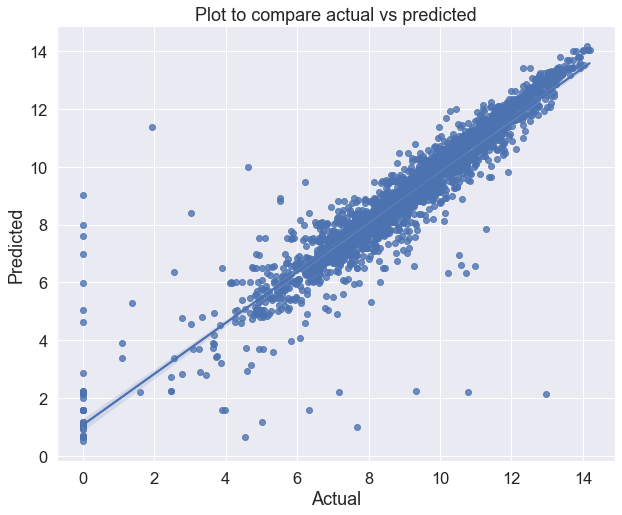

In [78]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Save the Model

In [79]:
filename = 'natpark.sav'
dump(xgbmodel,open(filename,'wb'))